In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
# Cargar el dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Entrenar el modelo de rbol de Decisi n con todos los atributos
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
# Evaluar el modelo
y_pred = clf.predict(X_test)
accuracy_all_features = accuracy_score(y_test, y_pred)
print(f"Exactitud con todos los atributos: {accuracy_all_features:.4f}")

Error cuadrático medio con todos los atributos: 5697.7895


In [13]:
# Configuración del Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Los primeros 'X_train.shape[1]' valores son las características, los siguientes son max_depth y min_samples_split
toolbox.register("attr_bool", lambda: random.randint(0, 1))  # Para las características (0 o 1)
toolbox.register("attr_max_depth", lambda: random.randint(2, 20))  # Para max_depth (profundidad entre 3 y 20)
toolbox.register("attr_min_samples_split", lambda: random.randint(2, 20))  # Para min_samples_split (2 a 20)

# Crear individuo con 30 características y los hiperparámetros max_depth y min_samples_split
def create_individual():
    features = [toolbox.attr_bool() for _ in range(X_train.shape[1])]  # 30 valores binarios
    max_depth = toolbox.attr_max_depth()  # Profundidad máxima del árbol
    min_samples_split = toolbox.attr_min_samples_split()  # Muestras mínimas para dividir
    individual = creator.Individual(features + [max_depth, min_samples_split])  # Convertir en un objeto Individual
    return individual

toolbox.register("individual", create_individual)

# Crear la población
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Función de evaluación
def evaluate(individual):
    # Las características seleccionadas son desde el primer elemento hasta el antepenúltimo
    selected_features = [i for i in range(len(individual) - 2) if individual[i] == 1]  # Ignorar los últimos dos valores
    max_depth = int(individual[-2])  # Penúltimo valor es max_depth
    min_samples_split = int(individual[-1])  # Último valor es min_samples_split

    if len(selected_features) == 0:
        return 0,  # Evitar selecciones vacías

    # Asegurarse de que selected_features no exceda el número de columnas
    if max(selected_features) >= X_train.shape[1]:
        print(individual, selected_features, X_train.shape)
        raise IndexError("Selected feature index is out of bounds.")

    # Seleccionar las características correctas del conjunto de entrenamiento y prueba
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Crear el clasificador con max_depth y min_samples_split del individuo
    clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split)
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)

    return accuracy_score(y_test, y_pred),

# Mutación de características, max_depth y min_samples_split
def custom_mutate(individual, indpb):
    # Mutar las características binarias (0/1)
    for i in range(len(individual) - 2):  # Características
        if random.random() < indpb:
            individual[i] = 1 if individual[i] == 0 else 0

    # Mutar max_depth
    if random.random() < indpb:
        individual[-2] = random.randint(3, 20)  # Mutar max_depth a un nuevo valor
    
    # Mutar min_samples_split
    if random.random() < indpb:
        individual[-1] = random.randint(2, 20)  # Mutar min_samples_split a un nuevo valor
    
    return individual,

# Operadores genéticos
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", custom_mutate, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Configuración del algoritmo genético
population = toolbox.population(n=100)
ngen = 100

# controla la probabilidad de realizar la operación de cruce (crossover) entre dos individuos durante el proceso de evolución.
cxpb = 0.5

# controla la probabilidad de aplicar la operación de mutación a un individuo durante el proceso de evolución.
mutpb = 0.2

# Ejecutar el algoritmo genético
result_population, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

# Seleccionar el mejor individuo
best_individual = tools.selBest(result_population, k=1)[0]

# Extraer las características seleccionadas, max_depth, y min_samples_split por separado
selected_features = [i for i in range(len(best_individual) - 2) if best_individual[i] == 1]  # Características
max_depth = best_individual[-2]  # Penúltimo valor es max_depth
min_samples_split = best_individual[-1]  # Último valor es min_samples_split

print(f"Mejores características seleccionadas: {selected_features}")
print(f"Max depth seleccionado: {max_depth}")
print(f"Min samples split seleccionado: {min_samples_split}")

best_fit = best_individual.fitness.values[0]  # El fitness es una tupla, por lo que accedes al primer valor
print(f"Best fitness: {best_fit}")

c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\usuario\anaconda3\envs\env_101\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Mejores características seleccionadas: [1, 3, 5, 7, 12, 13, 14, 16, 19, 20, 22, 23]
Max depth seleccionado: 3
Min samples split seleccionado: 11
Best fitness: 0.9824561403508771


In [10]:
# Entrenar con las mejores caractersticas seleccionadas
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split)
clf.fit(X_train_selected, y_train)
# Evaluar el modelo
y_pred = clf.predict(X_test_selected)
accuracy_selected_features = accuracy_score(y_test, y_pred)
# 0.9766
print(f"Exactitud con las mejores características: {accuracy_selected_features:.4f}")

Exactitud con las mejores características: 0.9766


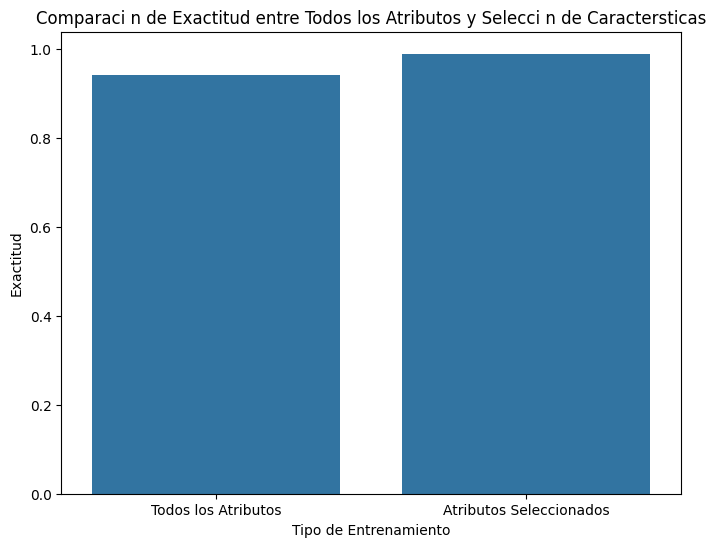

In [31]:
# Comparaci n de resultados
results = pd.DataFrame({
    'Tipo de Entrenamiento': ['Todos los Atributos', 'Atributos Seleccionados'],
    'Exactitud': [accuracy_all_features, accuracy_selected_features]
})
# Gr fico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo de Entrenamiento', y='Exactitud', data=results)
plt.title('Comparaci n de Exactitud entre Todos los Atributos y Selecci n de Caractersticas')
plt.show()